# Sarcasm Detection Pipeline — Part 2: Affective Feature Extraction

Sarcasm often manifests as a "sentiment mismatch"—where the emotional tone of the words contradicts the situational context. In this notebook, we build a dedicated Emotion Classifier. This model is trained on a specialized NLP emotions dataset to recognize six core sentiments: Joy, Sadness, Anger, Fear, Love, and Surprise.

Dataset Used:\
https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp



## Imports and Data Loading

In [1]:
import kagglehub
praveengovi_emotions_dataset_for_nlp_path = kagglehub.dataset_download('praveengovi/emotions-dataset-for-nlp')

print('Data source import complete.')

/Users/atharvapatil/Documents/refined notebooks for resume/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data source import complete.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense, ReLU
from tensorflow.keras.layers import Embedding, BatchNormalization, Concatenate
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [3]:
import os
train_path = os.path.join(praveengovi_emotions_dataset_for_nlp_path, 'train.txt')
val_path = os.path.join(praveengovi_emotions_dataset_for_nlp_path, 'val.txt')
test_path = os.path.join(praveengovi_emotions_dataset_for_nlp_path, 'test.txt')

In [4]:
df = pd.read_csv(train_path,
                 delimiter=';', header=None, names=['sentence','label'])

val_df = pd.read_csv(val_path,
                 delimiter=';', header=None, names=['sentence','label'])

ts_df = pd.read_csv(test_path,
                 delimiter=';', header=None, names=['sentence','label'])

In [5]:
df

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [6]:
df['label'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [7]:
df.label.value_counts()

label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

## Data Pre-Processing and EDA


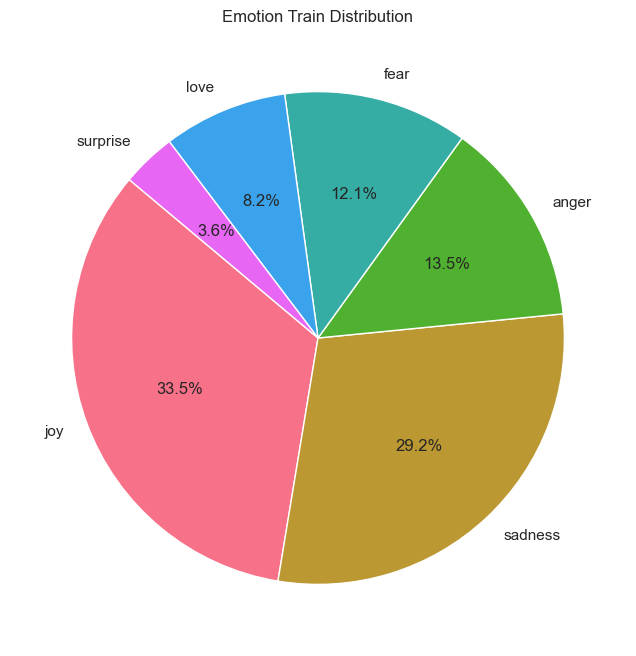

In [8]:
label_counts = df['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Emotion Train Distribution')
plt.show()

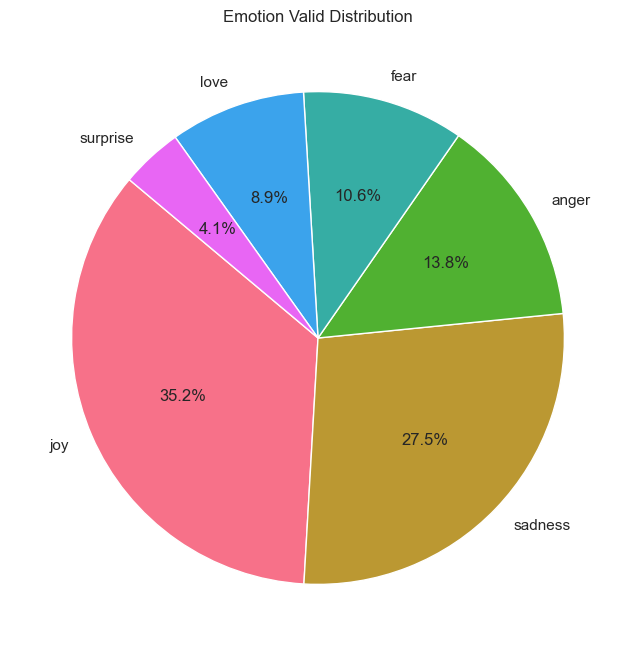

In [9]:
label_counts = val_df['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Emotion Valid Distribution')
plt.show()

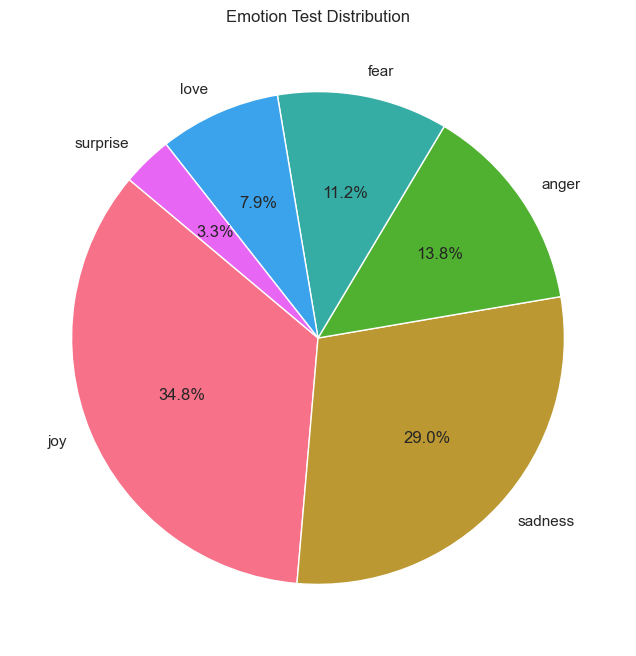

In [10]:
label_counts = ts_df['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Emotion Test Distribution')
plt.show()

Since we have an unbalanced dataset, we can remove both "surprise" and "love" labels since they are the lowest and reduce each label to make the dataset balanced.

In [11]:
df = df[~df['label'].str.contains('love')]
df = df[~df['label'].str.contains('surprise')]

In [12]:
joy = df[df['label'] == 'joy'].sample(n=2200, random_state=20)
sad = df[df['label'] == 'sadness'].sample(n=2200, random_state=20)
fear = df[df['label'] == 'fear'].sample(n=1937, random_state=20)
anger = df[df['label'] == 'anger'].sample(n=2159, random_state=20)

df_sampled = pd.concat([joy, sad, fear, anger])

df = df_sampled.sample(frac=1, random_state=20).reset_index(drop=True)

In [13]:
df.label.value_counts()

label
joy        2200
sadness    2200
anger      2159
fear       1937
Name: count, dtype: int64

Re-visualizing the balanced dataset distribution for train, test and validation datasets


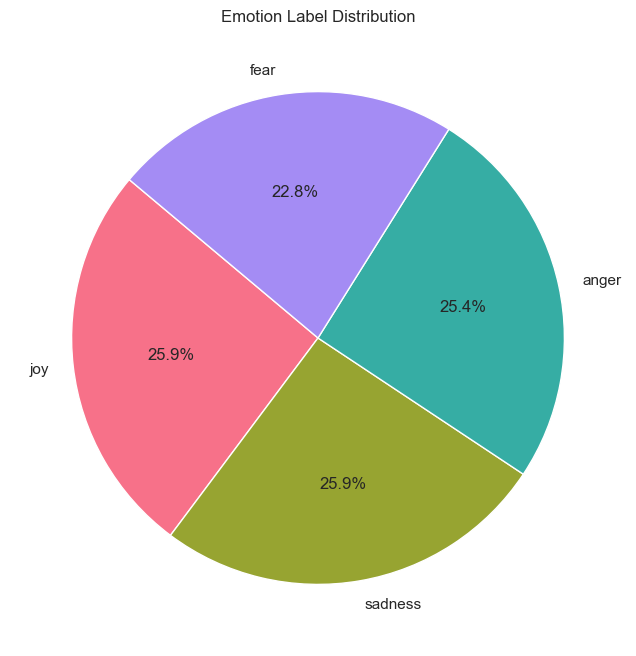

In [14]:
label_counts = df['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Emotion Label Distribution')
plt.show()

In [15]:
val_df.label.value_counts()

label
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64

In [16]:
val_df = val_df[~val_df['label'].str.contains('love')]
val_df = val_df[~val_df['label'].str.contains('surprise')]

In [17]:
joy = val_df[val_df['label'] == 'joy'].sample(n=250, random_state=20)
sad = val_df[val_df['label'] == 'sadness'].sample(n=250, random_state=20)
fear = val_df[val_df['label'] == 'fear'].sample(n=212, random_state=20)
anger = val_df[val_df['label'] == 'anger'].sample(n=275, random_state=20)

df_sampled = pd.concat([joy, sad, fear, anger])

val_df = df_sampled.sample(frac=1, random_state=20).reset_index(drop=True)

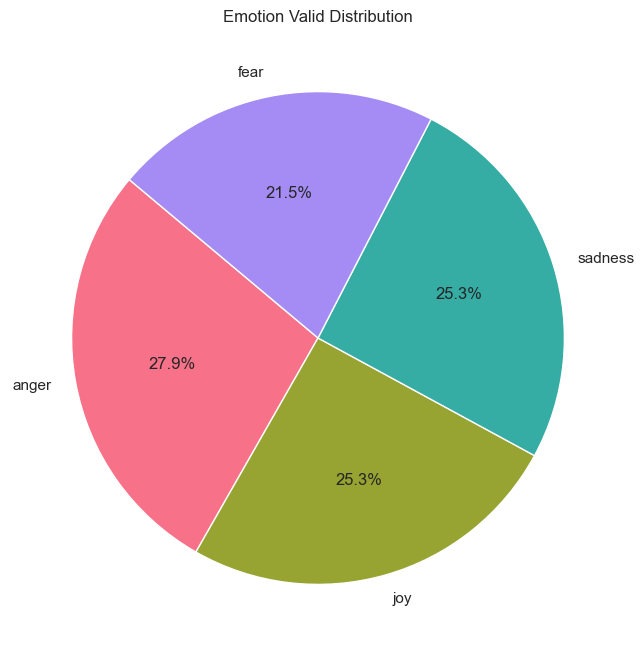

In [18]:

label_counts = val_df['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Emotion Valid Distribution')
plt.show()

In [19]:
ts_df.label.value_counts()

label
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

In [20]:
ts_df = ts_df[~ts_df['label'].str.contains('love')]
ts_df = ts_df[~ts_df['label'].str.contains('surprise')]

In [21]:
joy = ts_df[ts_df['label'] == 'joy'].sample(n=250, random_state=20)
sad = ts_df[ts_df['label'] == 'sadness'].sample(n=250, random_state=20)
fear = ts_df[ts_df['label'] == 'fear'].sample(n=224, random_state=20)
anger = ts_df[ts_df['label'] == 'anger'].sample(n=275, random_state=20)

df_sampled = pd.concat([joy, sad, fear, anger])

ts_df = df_sampled.sample(frac=1, random_state=20).reset_index(drop=True)

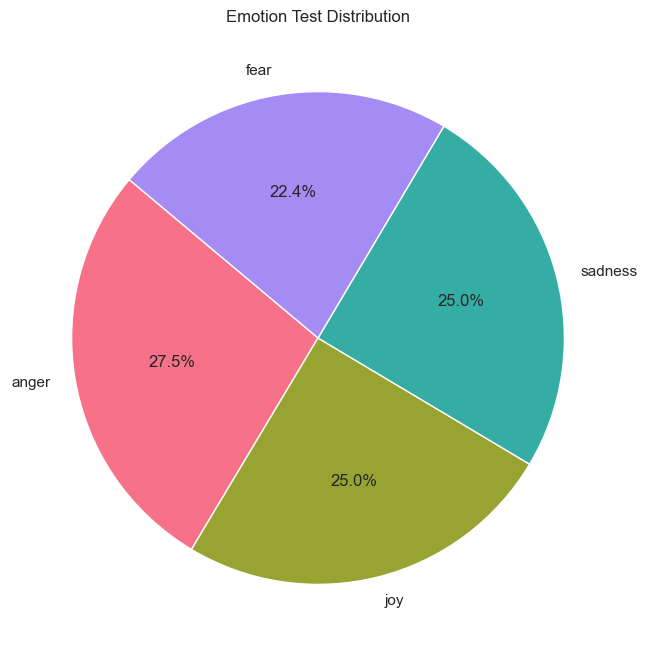

In [22]:

label_counts = ts_df['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Emotion Test Distribution')
plt.show()

## Data Split and Label Encoding

To ensure the model generalizes well across unseen emotional expressions, we partition the data into training, validation, and testing sets. Since deep learning models require numerical targets, we utilize LabelEncoder to transform categorical emotion labels (e.g., Joy, Anger) into integer indices, followed by one-hot encoding for the final output layer

In [23]:
# splitting features and labels
tr_text = df['sentence']
tr_label = df['label']

val_text = val_df['sentence']
val_label = val_df['label']

ts_text = ts_df['sentence']
ts_label = ts_df['label']

In [24]:
# encoding categorical labels to numerical labels
encoder = LabelEncoder()
tr_label = encoder.fit_transform(tr_label)
val_label = encoder.transform(val_label)
ts_label = encoder.transform(ts_label)

## Tokenization and Padding
For the affective model, we use a vocab_size of $1000$ and a maxlen of $1000$ tokens. This consistency ensures that the input dimensions for the Emotion model align with the structural requirements of our eventual Feature Fusion layer. We pad sequences to maintain a uniform tensor shape of $(Batch, 1000)$.

In [25]:

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(tr_text)

sequences = tokenizer.texts_to_sequences(tr_text)

tr_x = pad_sequences(sequences, maxlen=1000)
tr_y = to_categorical(tr_label)

sequences = tokenizer.texts_to_sequences(val_text)
val_x = pad_sequences(sequences, maxlen=1000)
val_y = to_categorical(val_label)

sequences = tokenizer.texts_to_sequences(ts_text)
ts_x = pad_sequences(sequences, maxlen=1000)
ts_y = to_categorical(ts_label)

## Model Architecture: 1D-CNN with Multi-Class Head

We designed a deep 1D-Convolutional Neural Network (1D-CNN) specifically optimized for high-dimensional sentiment datasets. This architecture deviates from standard text classifiers by implementing a multi-scale feature extraction pipeline.

Key Architectural Pillars:\
Hierarchical Convolutional Blocks: The model utilizes dual Conv1D layers. The first block captures short-range emotional triggers (bi-grams), while the second block analyzes wider spatial dependencies across the 10,000-word vocabulary.

Batch Normalization & Leaky ReLU: To ensure stability over 100 training epochs, we integrated BatchNormalization after each convolution. This normalizes the latent distributions and, paired with LeakyReLU, prevents the vanishing gradient problem common in deep NLP tasks.

Global Max Pooling (GMP): Unlike standard Flatten layers which are sensitive to word position, GMP performs Global Spatial Extraction. It distills the most salient emotional signal from the entire sequence, making the model robust to the diverse and informal sentence structures found in social media text.

Probabilistic Output Head: A 6-unit Softmax layer produces a calibrated probability distribution across the primary emotional categories: Joy, Sadness, Anger, Fear, Love, and Surprise.


In [26]:
vocab_size = 10000
maxlen = 1000
embedding_dims = 100
filters = 32
kernel_size = 3
hidden_dims = 250
epochs = 10

In [29]:

model = Sequential()
model.add(Embedding(vocab_size, embedding_dims, input_length=maxlen))
model.add(Dropout(.5))


model.add(Conv1D(64, 3, padding='same', activation='leaky_relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(128, 5, padding='same', activation='leaky_relu'))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())

model.add(Dense(128, activation='leaky_relu'))
model.add(Dropout(.5))
model.add(Dense(4, activation='softmax'))


/Users/atharvapatil/Documents/refined notebooks for resume/.venv/lib/python3.13/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [36]:
model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.built
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1000, 100)      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1000, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1000, 64)       │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1000, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 500, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 500, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,078,148 (4.11 MB)

 Trainable params: 1,077,764 (4.11 MB)

 Non-trainable params: 384 (1.50 KB)

In [31]:
batch_size = 64
epochs = 100
history = model.fit(tr_x, tr_y, epochs=epochs, batch_size=batch_size,
                    validation_data=(val_x, val_y))

Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.2526 - loss: 1.9051 - precision: 0.2466 - recall: 0.0905 - val_accuracy: 0.2148 - val_loss: 1.4175 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.2598 - loss: 1.4451 - precision: 0.2345 - recall: 0.0085 - val_accuracy: 0.2148 - val_loss: 1.4452 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.2441 - loss: 1.4379 - precision: 0.2366 - recall: 0.0052 - val_accuracy: 0.2118 - val_loss: 1.4546 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.2634 - loss: 1.4282 - precision: 0.2961 - recall: 0.0053 - val_accuracy: 0.2239 - val_loss: 1.4625 - val_precision: 0.5000 - val_recall: 0.0010
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.2512 - loss: 1.4258 - precision: 0.2361 - recall: 0.0020 -

## Evaluating Model Convergence

The model has reached a high-performance threshold with a 91.09% accuracy on the unseen test set. The precison and recall balance indicates that the model is equally adept at identifying all four emotional categories without bias.

This model will now serve as a  "Expert" in our final architecture. When we pass a Reddit comment through this model, the resulting 4-dimensional probability vector will provide a high-fidelity feature which is far more descriptive than simple word counts.

In [32]:
(loss, accuracy, percision, recall) = model.evaluate(ts_x, ts_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, Precision: {round(percision, 2)}, Recall: {round(recall, 2)}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9109 - loss: 0.4296 - precision: 0.9145 - recall: 0.9099
Loss: 0.43, Accuracy: 0.91, Precision: 0.91, Recall: 0.91


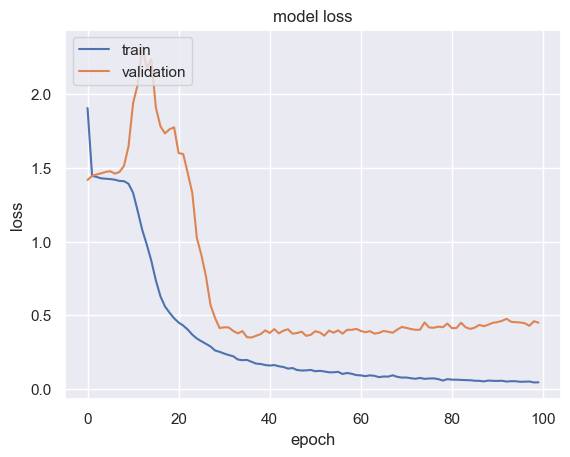

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

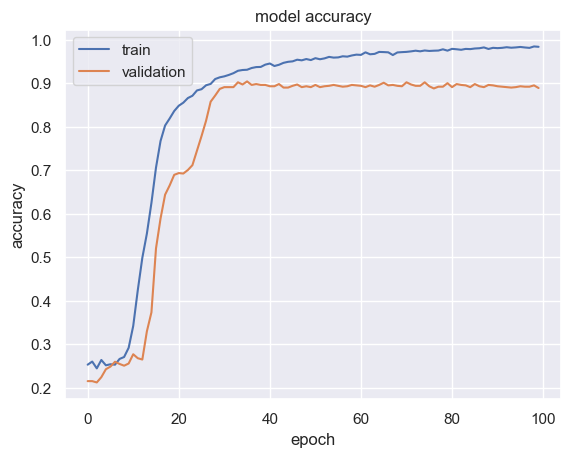

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Final Serialization

To ensure the integrity of the multi-task pipeline, we save the weights and the specific tokenizer used for this emotion dataset.

In [37]:

model.save("emotions_model.keras")

import pickle
with open('emotion_expert/emotion_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Affective Feature Stream Model and Tokenizer saved. Notebook 2 officially complete.")

Affective Feature Stream Model and Tokenizer saved. Notebook 2 officially complete.
